The purpose of this notebook is to combine all retina data from the [Rodent Research 9](https://osdr.nasa.gov/bio/repo/data/payloads/RR-9) (RR9) mission from the [NASA Open Science Data Repository](https://www.nasa.gov/osdr/ (OSDR)), perform exploratory data analysis, and train a digital twin.

Testing needs to be done to see whether a larger synthetic dataset should be generated prior to digital twin training; and the ML model for the digital twin has not been identified yet.

Future work could also include incorporating the raw image data from [OSD-568](https://osdr.nasa.gov/bio/repo/data/studies/OSD-568) and [OSD-557](https://osdr.nasa.gov/bio/repo/data/studies/OSD-557), and environmental data from RR-9 (https://visualization.osdr.nasa.gov/eda/).


Feel free to make a copy of this notebook and change or add to it. Fill in your name below.

**Original Author:** Lauren Sanders

**Additional Author(s):**

# Data Preparation

Combine and merge 5 RR-9 datasets with different measurements on the mouse retina. Not all measurements are available for all samples (see the [RR9 Sample and Dataset sheet](https://docs.google.com/spreadsheets/d/1uZbj4rXpEWZJDywE7HAvwR5v7RNDtVyG/edit?gid=1036112252#gid=1036112252)).

1. [OSD-255](https://osdr.nasa.gov/bio/repo/data/studies/OSD-255): Gene expression quantification through RNA sequencing (right eye).

2. [OSD-568](https://osdr.nasa.gov/bio/repo/data/studies/OSD-568): Immunostaining quantification of 2 molecular markers related to blood-retinal barrier integrity: ZO1 and PECAM; and quantification of DNA damage from the TUNEL assay (left eye).

3. [OSD-557](https://osdr.nasa.gov/bio/repo/data/studies/OSD-557): Quantification of the [structure of the eye using microCT](https://pubmed.ncbi.nlm.nih.gov/33191924/); and immunostaining quantification of [PNA, a molecular marker for eye cone degradation](https://www.nature.com/articles/s41598-019-49453-x); and quantification of [H&E stain](https://en.wikipedia.org/wiki/H%26E_stain) for different cell components (left eye).

4. [OSD-583](https://osdr.nasa.gov/bio/repo/data/studies/OSD-583): Quantification of intra-ocular pressure through tonometry (both eyes).

5. [OSD-715](https://osdr.nasa.gov/bio/repo/data/studies/OSD-715): Protein expression quantification through mass spectrometry (left eye).

In [2]:
import pandas as pd
import requests

In [3]:
## Using the Data API from the OSDR Public API
## Documentation: https://www.nasa.gov/reference/osdr-public-api/

rnaseq = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-255/download?source=datamanager&file=GLDS-255_rna_seq_Normalized_Counts.csv', index_col=0).transpose()

zo1 = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-568/download?source=datamanager&file=LSDS-5_immunostaining_microscopy_Zo-1tr_TRANSFORMED.csv')

tunel = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-568/download?source=datamanager&file=LSDS-5_immunostaining_microscopy_TUNELtr_TRANSFORMED.csv')

pecam = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-568/download?source=datamanager&file=LSDS-5_immunostaining_microscopy_PECAMtr_TRANSFORMED.csv')#['Source Name']=['F15','F16','F17','F18','F19','F20','GC15','GC16','GC17','GC18','GC19']

microct = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-557/download?source=datamanager&file=LSDS-1_microCT_MicroCT_Transformed_Reusable_Results.csv') #NOTE: OSD-557 also has raw image files for immunostaining and H&E

pna = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-557/download?source=datamanager&file=LSDS-1_immunostaining_microscopy_PNAtr_Transformed_Reusable_Results.csv')

hne = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-557/download?source=datamanager&file=LSDS-1_immunostaining_microscopy_HNEtr_Transformed_Reusable_Results.csv')

tonometry = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-583/download?source=datamanager&file=LSDS-16_tonometry_maoTRANSFORMED.csv')

protein = pd.read_excel('https://osdr.nasa.gov/geode-py/ws/studies/OSD-715/download?source=datamanager&file=GLDS-639_proteomics_01_Mao_RR9_Retina_092018_MQ_iBAQ.xlsx', sheet_name='Combat corrected', index_col=0).transpose()
protein = protein.drop(protein.columns[[0, 1, 2, 4, 5, 6]], axis=1).rename(columns={"Sample": "Source Name"}).reset_index().drop(columns=['index']) # remove some Excel formatting
protein = protein.set_index('Source Name').apply(pd.to_numeric, errors='coerce') # convert to numeric instead of dtype "object"


In [4]:
print(rnaseq.shape)
print(protein.shape)

(16, 23419)
(12, 6634)


In [5]:
# Filter omics data:
# - remove genes and proteins with greater than 1% zero values
# - keep 1000 genes and 1000 proteins with highest variance

rnaseq = rnaseq.loc[:, (rnaseq == 0).mean() < 0.01]  # Remove features with too many zeros
print(rnaseq.shape)
rnaseq = rnaseq.loc[:, rnaseq.var().nlargest(1000).index]  # Take top 1000 features by variance

protein = protein.loc[:, (protein == 0).mean() < 0.01]  # Remove features with too many zeros
print(protein.shape)
protein = protein.loc[:, protein.var().nlargest(1000).index]  # Take top 1000 features by variance

(16, 17424)
(12, 6634)


In [6]:
all_genes = rnaseq.columns.tolist() # get all gene names for later
all_proteins = protein.columns.tolist() # get all protein names for later

In [7]:
# Add Source Name to all the dfs that are missing it
# Rename some Source Names that already exist

#Fviv = CC1 (confirmed in OSD-583 metadata)
#GViv = CC2?

gsm_dict = {
    "GSM3932702": "F11",
    "GSM3932703": "F15",
    "GSM3932704": "F16",
    "GSM3932705": "F17",
    "GSM3932706": "F18",
    "GSM3932707": "F19",
    "GSM3932708": "F20",
    "GSM3932694": "GC11",
    "GSM3932695": "GC15",
    "GSM3932696": "GC16",
    "GSM3932697": "GC17",
    "GSM3932698": "GC18",
    "GSM3932699": "GC19",
    "GSM3932700": "GC20",
    "GSM3932693": "GC9",
    "GSM3932701": "F9"
}

rnaseq['Source Name'] = rnaseq.index.map(gsm_dict)

zo1['Source Name'] = ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19', 'GC20']

tunel['Source Name'] = ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19', 'GC20', 'CC2_15', 'CC2_16', 'CC2_17', 'CC2_18', 'CC2_20', 'Viv15', 'Viv16', 'Viv17', 'Viv18', 'Viv19', 'Viv20'] #rename VG to CC2 and V to Viv for consistency

pecam['Source Name'] = ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19']

microct['Source Name'] = ['F10', 'F12', 'F13', 'F14', 'Viv10', 'Viv12', 'Viv13', 'Viv14', 'GC10', 'GC11', 'GC13', 'GC14'] #rename V to Viv

hne['Source Name'] = ["F15", "F16", "F17", "F18", "F19", "F20", "GC15", "GC16", "GC17", "GC18", "GC19", "Viv15", "Viv16", "Viv17", "Viv18", "Viv19", "Viv20", "CC2_15", "CC2_16", "CC2_17", "CC2_18", "CC2_19", "CC2_20"]

tonometry['Source Name'] = ["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12", "F13", "F14", "F15", "F16", "F17", "F18", "F19", "F20", "CC1_1", "CC1_2", "CC1_3", "CC1_4", "CC1_5", "CC1_6", "CC1_7", "CC1_8", "CC1_9", "CC1_10", "CC1_11", "CC1_12", "CC1_13", "CC1_14", "CC1_15", "CC1_16", "CC1_17", "CC1_18", "CC1_19", "CC1_20", "GC1", "GC2", "GC3", "GC4", "GC5", "GC6", "GC7", "GC8", "GC9", "GC10", "GC11", "GC12", "GC13", "GC14", "GC15", "GC16", "GC17", "GC18", "GC19", "GC20", "Viv1", "Viv2", "Viv3", "Viv4", "Viv5", "Viv6", "Viv7", "Viv8", "Viv9", "Viv10", "Viv11", "Viv12", "Viv13", "Viv14", "Viv15", "Viv16", "Viv17", "Viv18", "Viv19", "Viv20", "CC2_1", "CC2_2", "CC2_3", "CC2_4", "CC2_5", "CC2_6", "CC2_7", "CC2_8", "CC2_9", "CC2_10", "CC2_11", "CC2_12", "CC2_13", "CC2_14", "CC2_15", "CC2_16", "CC2_17", "CC2_18", "CC2_19", "CC2_20"] #rename "FViv" to "CC1"  for consistency

protein['Source Name'] = protein.index
protein.reset_index(drop=True, inplace=True)


In [8]:
# Drop "Sample Name" and a couple other irrelevant columns
zo1.drop(columns=['Sample_Name'], inplace=True)
tunel.drop(columns=['Sample_Name'], inplace=True)
pecam.drop(columns=['Sample_Name'], inplace=True)
microct.drop(columns=['Sample Name', 'Treatment'], inplace=True)
pna.drop(columns=['Sample Name', 'Treatment'], inplace=True)
hne.drop(columns=['Sample Name'], inplace=True)
tonometry.drop(columns=['Sample Name', 'Factor Value: Spaceflight', 'time_Start', 'Time_End'], inplace=True)

In [9]:
# Add suffix to all physiological data column names to avoid duplicates (rnaseq and protein should be unique)
zo1.columns = [col + '_zo1' if col != 'Source Name' else col for col in zo1.columns]
tunel.columns = [col + '_tunel' if col != 'Source Name' else col for col in tunel.columns]
pecam.columns = [col + '_pecam' if col != 'Source Name' else col for col in pecam.columns]
microct.columns = [col + '_microct' if col != 'Source Name' else col for col in microct.columns]
pna.columns = [col + '_pna' if col != 'Source Name' else col for col in pna.columns]
hne.columns = [col + '_hne' if col != 'Source Name' else col for col in hne.columns]
tonometry.columns = [col + '_tonometry' if col != 'Source Name' else col for col in tonometry.columns]

## Merge dataframes

Merge all dataframes on the "Source Name" column, filling empty data values with "NaN"

In [10]:
dfs = [rnaseq, protein, zo1, tunel, pecam, microct, pna, hne, tonometry]

# Convert 'Source Name' to string in all DataFrames to avoid dtype conflicts
for df in dfs:
    df['Source Name'] = df['Source Name'].astype(str)

# Merge all DataFrames on "Source Name" column
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on="Source Name", how="outer")

# Move source name column to the front
column_to_move = merged_df.pop("Source Name")
merged_df.insert(0, "Source Name", column_to_move)

pd.set_option('display.max_rows', None)

merged_df

,Source Name,ENSMUSG00000118866,ENSMUSG00000118841,ENSMUSG00002076161,ENSMUSG00000030324,ENSMUSG00000092341,ENSMUSG00000024041,ENSMUSG00000034837,ENSMUSG00000119584,ENSMUSG00000064370,...,dentotal_hne,denEC_hne,Left_1_tonometry,Left_2_tonometry,Left_3_tonometry,Avg_Left_tonometry,Right_1_tonometry,Right_2_tonometry,Right_3_tonometry,Avg_Right_tonometry
0,CC1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,19,17,18,18.000000,16,14,15,15.000000
1,CC1_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16,18,16,16.666667,19,14,14,15.666667
2,CC1_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16,14,15,15.000000,17,15,18,16.666667
3,CC1_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17,16,15,16.000000,16,18,20,18.000000
4,CC1_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15,17,14,15.333333,15,15,13,14.333333
5,CC1_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11,10,13,11.333333,18,14,14,15.333333
6,CC1_15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17,21,21,19.666667,15,14,13,14.000000
7,CC1_16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20,18,16,18.000000,11,12,9,10.666667
8,CC1_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,21,20,17,19.333333,10,11,13,11.333333
9,CC1_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13,15,13,13.666667,13,14,13,13.333333


In [11]:
all_phys = [x for x in merged_df.drop(columns='Source Name').columns if x not in all_genes and x not in all_proteins]

In [12]:
# Add a group column
merged_df['Group'] = [
    "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1",
    "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1",
    "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2",
    "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2",
    "F", "F", "F", "F", "F", "F", "F", "F", "F", "F",
    "F", "F", "F", "F", "F", "F", "F", "F", "F", "F",
    "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC",
    "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC",
    "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv",
    "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv"
]

---
There are 5 different experimental groups within the dataset: CC1, CC2, F, GC, and Viv. Definitions are below.

**CC1** = (cohort control 1) Due to Hurricane Irma’s impact on KSC in September, 2017, experiments with both GC and GV (Viv) control groups were cancelled and later rescheduled for May, 2018, using mice of the same strain, sex, age and animals were from the same holding room from the vendor that were used for the flight experiments. This resulted in a large time gap between tissue collection for the flight and KSC ground control groups. Consequently, the FV (CC1) cohort-matched control group was added to the study to help control for possible differences associated with this delay.

**CC2** = (cohort control 2) Ground cohort-matched control group.

**F** = (flight) mice housed on the International Space Station for 35 days.

**GC** = (ground control) matched cohort to the flight mice; lived on Earth the duration of the mission in flight habitats.

**Viv** = (vivarium) matched cohort to the flight mice; lived on Earth the duration of the mission in normal vivarium habitats.

---

## Scale the data

Since the RNAseq data is on a very different scale from the rest of the data, scale the whole dataset between 0-1 for comparability.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# What's the max value in the merged data?

merged_df.drop('Group', axis=1).set_index('Source Name').max().max()

817690.021356568

In [15]:
## Plot histogram distribution of all numerical values in the merged data

# Select only numeric columns and flatten them into a single list, ignoring NaN values
numeric_values = merged_df.select_dtypes(include=np.number).values.flatten()
numeric_values = numeric_values[~np.isnan(numeric_values)]  # Remove NaN values


In [16]:
len(numeric_values)


29237

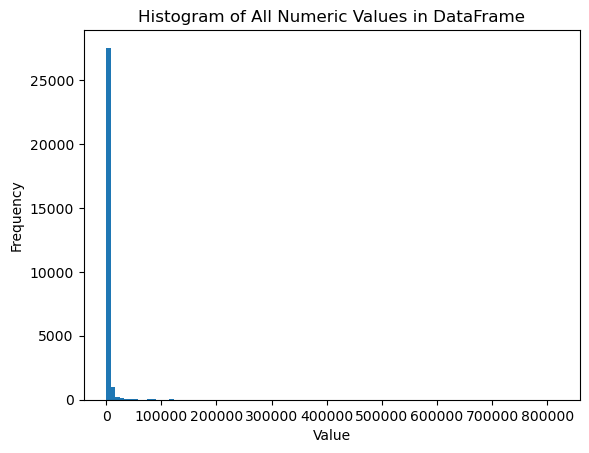

In [17]:
# Plot the histogram
plt.hist(numeric_values, bins=100) #1000 without variance filtering
plt.title("Histogram of All Numeric Values in DataFrame")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [18]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max scale the data
scaler = MinMaxScaler()
df = merged_df.drop('Group', axis=1).set_index('Source Name')
merged_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


In [19]:
merged_scaled.max().max()

1.0000000000000009

In [20]:
## Plot histogram distribution of all numerical values in the merged SCALED data

# Select only numeric columns and flatten them into a single list, ignoring NaN values
numeric_values = merged_scaled.select_dtypes(include='number').values.flatten()
numeric_values = numeric_values[~np.isnan(numeric_values)]  # Remove NaN values


In [21]:
len(numeric_values)


29237

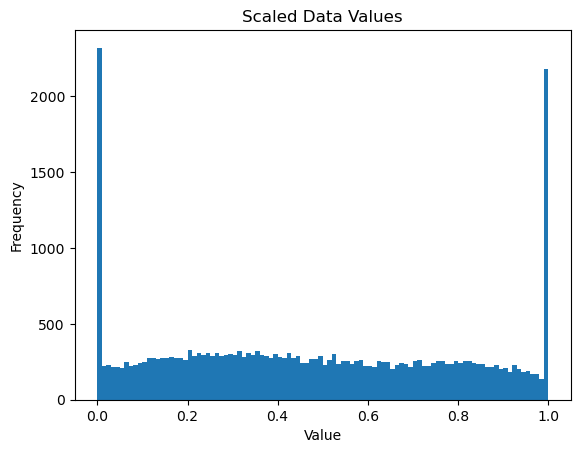

In [22]:
# Plot the histogram
plt.hist(numeric_values, bins=100)
plt.title("Scaled Data Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [23]:
# Add back in the "Group" column

merged_scaled['Group'] = merged_df.set_index('Source Name')["Group"]


## All data all samples

Text(0.5, 1.0, 'Data Types')

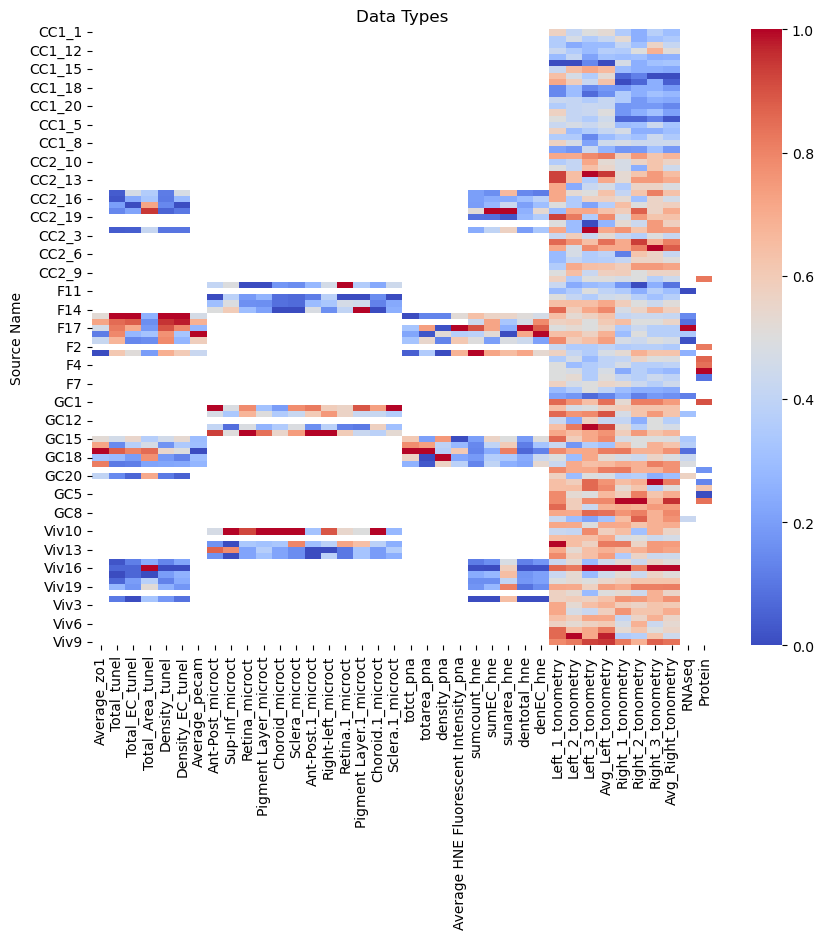

In [24]:
# create heatmap showing which samples have which data types

plt.figure(figsize=(10, 8))
sns.heatmap(merged_scaled[all_phys + [all_genes[0], all_proteins[0]]].rename(columns={all_genes[0]: 'RNAseq', all_proteins[0]: 'Protein'}),
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Data Types")


## Impute missing values

Since not all measurements are available for all animals, impute the missing values based on the available values.

NOTE - this is not necessarily the only thing to do. Feel free to try different approaches.

### Iterative Imputer

This is one option for imputing values. Code is below but commented out for now. The imputed values looked very similar across all samples.

https://scikit-learn.org/1.5/modules/generated/sklearn.impute.IterativeImputer.html



In [25]:
'''
***A few params to adjust for compute/memory constraints:

n_nearest_features (int, default=None)
Number of other features to use to estimate the missing values of each feature column. Nearness between features is measured using the absolute correlation coefficient between each feature pair (after initial imputation). To ensure coverage of features throughout the imputation process, the neighbor features are not necessarily nearest, but are drawn with probability proportional to correlation for each imputed target feature. Can provide significant speed-up when the number of features is huge. If None, all features will be used.
*Finishes with 15; crashes with 100.

max_iter (int, default=10)
Maximum number of imputation rounds to perform before returning the imputations computed during the final round. A round is a single imputation of each feature with missing values. The stopping criterion is met once max(abs(X_t - X_{t-1}))/max(abs(X[known_vals])) < tol, where X_t is X at iteration t. Note that early stopping is only applied if sample_posterior=False.

skip_complete (bool, default=False)
If True then features with missing values during transform which did not have any missing values during fit will be imputed with the initial imputation method only. Set to True if you have many features with no missing values at both fit and transform time to save compute.
'''

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# imp = IterativeImputer(n_nearest_features=100, max_iter=5, random_state=0, skip_complete=True)

'\n***A few params to adjust for compute/memory constraints:\n\nn_nearest_features (int, default=None)\nNumber of other features to use to estimate the missing values of each feature column. Nearness between features is measured using the absolute correlation coefficient between each feature pair (after initial imputation). To ensure coverage of features throughout the imputation process, the neighbor features are not necessarily nearest, but are drawn with probability proportional to correlation for each imputed target feature. Can provide significant speed-up when the number of features is huge. If None, all features will be used.\n*Finishes with 15; crashes with 100.\n\nmax_iter (int, default=10)\nMaximum number of imputation rounds to perform before returning the imputations computed during the final round. A round is a single imputation of each feature with missing values. The stopping criterion is met once max(abs(X_t - X_{t-1}))/max(abs(X[known_vals])) < tol, where X_t is X at i

In [26]:
# Completes in ~8 min

# imp_df = imp.fit_transform(merged_df.drop(columns=['Source Name', 'Group']))

In [27]:
# imp_df = pd.DataFrame(imp_df, columns=merged_df.drop(columns=['Source Name', 'Group']).columns)
# imp_df['Source Name'] = merged_df['Source Name']
# imp_df['Group'] = merged_df['Group']

# imp_df

### KNN Imputer

Another option for imputing values. Currently using this option.

https://scikit-learn.org/1.5/modules/generated/sklearn.impute.KNNImputer.html

Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

**Fewer neighbors are better (~2)**

In [28]:
from sklearn.impute import KNNImputer
imp_knn = KNNImputer(n_neighbors=2, weights='distance') # ? *** systematic test of the n_neighbors


In [29]:
# impute the physiological data first

imp_phys = imp_knn.fit_transform(merged_scaled[all_phys])
imp_phys = pd.DataFrame(imp_phys, columns=all_phys, index=merged_scaled.index)


In [30]:
# collect the scaled omics data in 1 df

omics_scaled = merged_scaled[[x for x in merged_scaled.columns if x in all_genes or x in all_proteins]]


In [31]:
# merge omics_scaled and imp_phys


# Merge all DataFrames on "Source Name" column
temp = pd.merge(imp_phys, omics_scaled, on="Source Name", how="outer")



In [32]:
# impute the omics data using the newly imputed physiological data

imp_df_knn = imp_knn.fit_transform(temp)

In [33]:
# Add back in Group column and index (Source Names)

imp_df_knn = pd.DataFrame(imp_df_knn, columns=merged_scaled.drop(columns='Group').columns)
imp_df_knn.index = merged_scaled.index
imp_df_knn['Group'] = merged_scaled['Group']

#imp_df_knn

In [34]:
## Original code imputing all the data at once

# from sklearn.impute import KNNImputer

# imp_knn = KNNImputer(n_neighbors=2, weights='distance')
# imp_df_knn = imp_knn.fit_transform(merged_scaled.drop(columns='Group'))

## Validating imputation

Withold 2 RNAseq samples and impute them (F11 and GC11)

Calculate correlation between ground truth RNAseq samples and imputed RNAseq samples

In [35]:
# replace F11 and G11 with NaN
omics_scaled_del = omics_scaled.copy()
omics_scaled_del.loc['F11'] = np.nan
omics_scaled_del.loc['GC11'] = np.nan

In [36]:
# Impute

imp_df_knn_del = imp_knn.fit_transform(pd.merge(imp_phys, omics_scaled_del, on="Source Name", how="outer"))


imp_df_knn_del = pd.DataFrame(imp_df_knn_del, columns=merged_scaled.drop(columns='Group').columns)
imp_df_knn_del.index = merged_scaled.index
imp_df_knn_del['Group'] = merged_scaled['Group']

In [37]:
# Calculate correlation

from scipy.stats import spearmanr

f11_real = merged_scaled.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['F11']
gc11_real = merged_scaled.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['GC11']

f11_imp = imp_df_knn_del.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['F11']
gc11_imp = imp_df_knn_del.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['GC11']

print(spearmanr(f11_real, f11_imp))
print(spearmanr(gc11_real, gc11_imp))


SignificanceResult(statistic=-0.03241622203976014, pvalue=0.30579844425165875)
SignificanceResult(statistic=-0.010471469902070816, pvalue=0.7408470335253843)


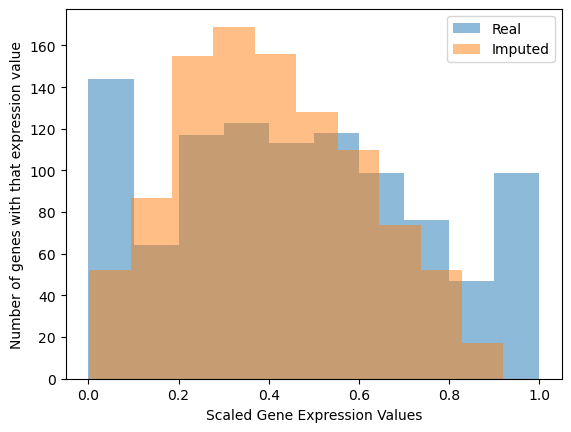

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


# histogram of f11_real overlaid with f11_imp in a different color

plt.hist(f11_real, bins=10, alpha=0.5, label='Real')
plt.hist(f11_imp, bins=10, alpha=0.5, label='Imputed')
plt.ylabel('Number of genes with that expression value')
plt.xlabel('Scaled Gene Expression Values')
plt.legend()
plt.show()



In [39]:
len(f11_real)

1000

In [40]:
f11_real

ENSMUSG00000118866    0.000000
ENSMUSG00000118841    0.000000
ENSMUSG00002076161    0.055638
ENSMUSG00000030324    0.233594
ENSMUSG00000092341    0.666007
ENSMUSG00000024041    0.008890
ENSMUSG00000034837    0.635760
ENSMUSG00000119584    0.816570
ENSMUSG00000064370    0.559304
ENSMUSG00000064351    0.495542
ENSMUSG00000064363    0.417284
ENSMUSG00000064339    0.422836
ENSMUSG00000064341    0.381133
ENSMUSG00000064357    0.296031
ENSMUSG00000092837    0.479417
ENSMUSG00000064367    0.555033
ENSMUSG00000064358    0.386292
ENSMUSG00000056055    0.072788
ENSMUSG00000032060    0.015304
ENSMUSG00000029064    0.089365
ENSMUSG00000100862    0.945427
ENSMUSG00000088088    0.531063
ENSMUSG00000042240    0.014711
ENSMUSG00000064345    0.584283
ENSMUSG00000041534    0.426830
ENSMUSG00000101111    0.417322
ENSMUSG00000102070    0.554911
ENSMUSG00000032294    0.177762
ENSMUSG00000000724    0.009209
ENSMUSG00000031293    0.239380
ENSMUSG00000006007    0.000000
ENSMUSG00000065701    0.228029
ENSMUSG0

### Comparison of pre/post imputation

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Heatmaps

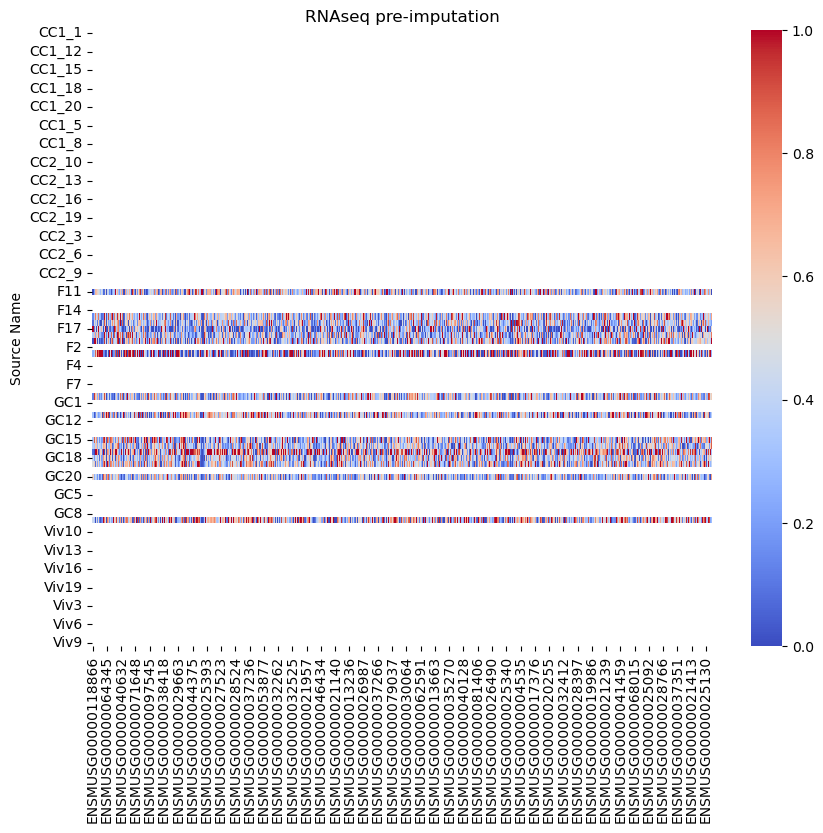

In [42]:
# RNAseq data pre-imputation

df = merged_scaled.drop(columns='Group')[all_genes]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))
            #mask=df.isnull()


plt.title("RNAseq pre-imputation")

plt.show()


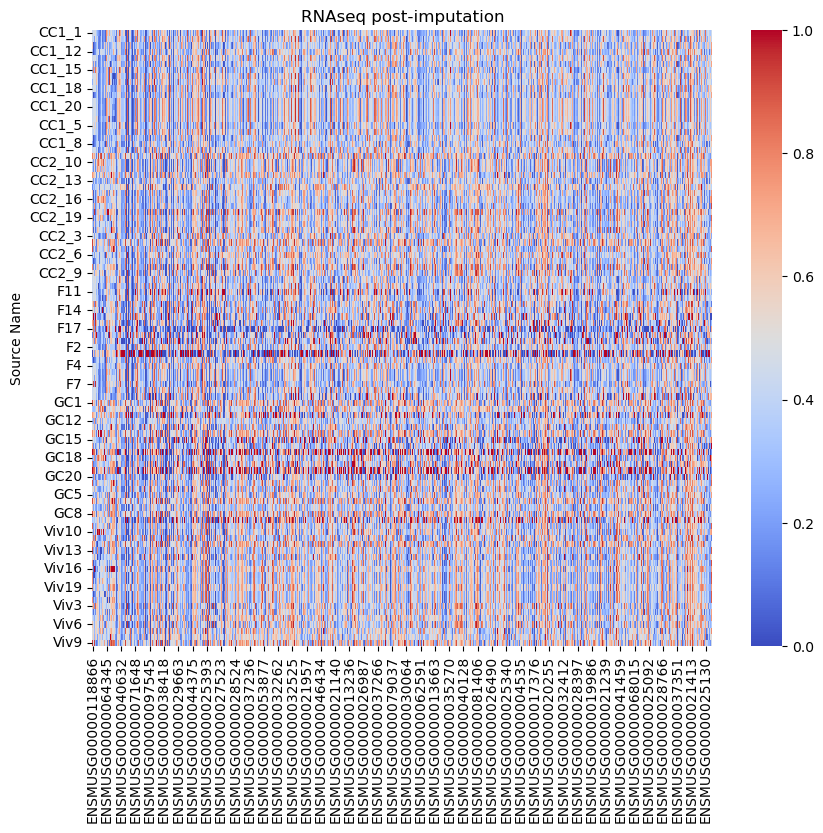

In [43]:
# RNAseq data post-imputation

df = imp_df_knn.drop(columns='Group')[all_genes]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("RNAseq post-imputation")

plt.show()


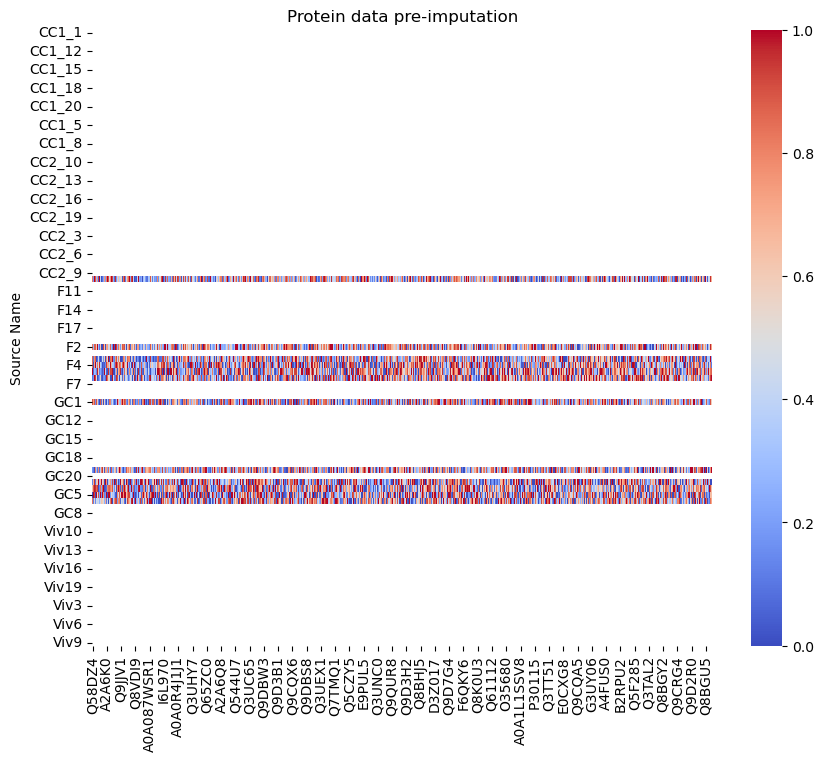

In [44]:
# Protein data pre-imputation

df = merged_scaled.drop(columns='Group')[all_proteins]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Protein data pre-imputation")
plt.show()


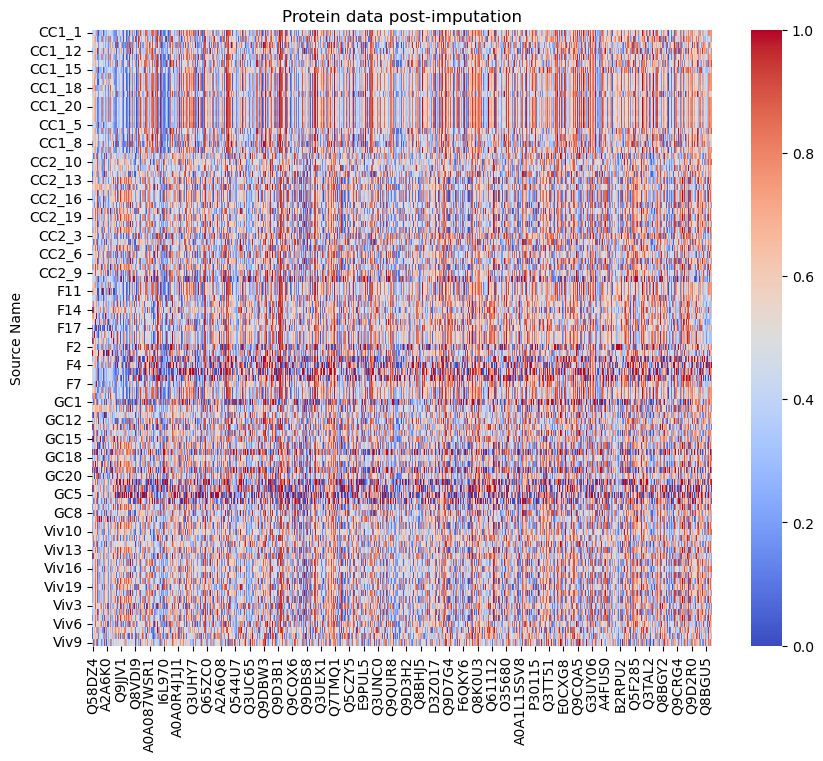

In [45]:
# Protein data post-imputation

df = imp_df_knn.drop(columns='Group')[all_proteins]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Protein data post-imputation")
plt.show()


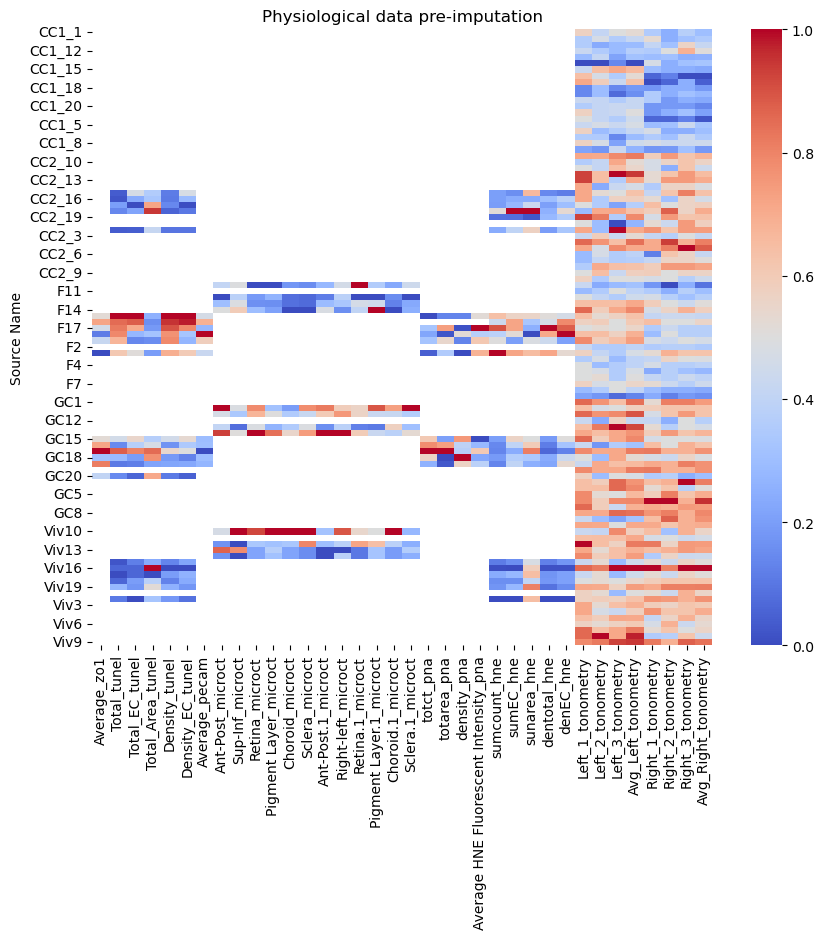

In [46]:
# Physiological data pre-imputation

df = merged_scaled.drop(columns='Group')
df = df[all_phys]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Physiological data pre-imputation")
plt.show()


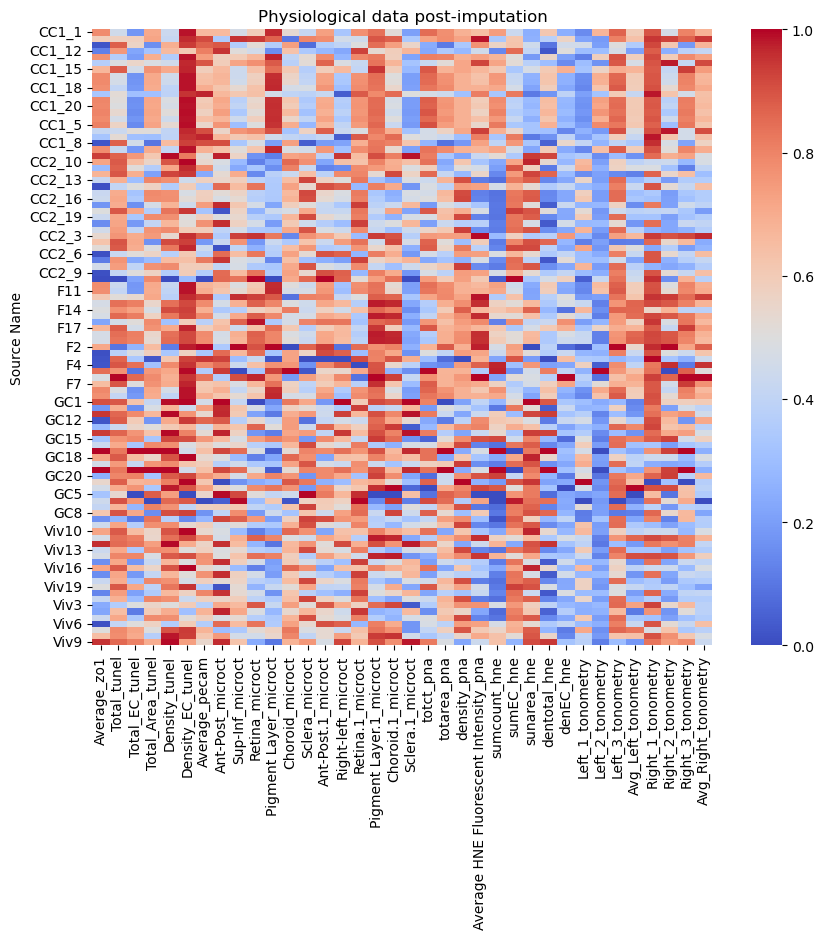

In [47]:
# Physiological data post-imputation

df = imp_df_knn.drop(columns='Group')
df = df[all_phys]


plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Physiological data post-imputation")
plt.show()


#### Histograms

In [48]:
group_colors = {'GC': 'green', 'F': 'blue', 'Viv': 'red', 'CC1': 'purple', 'CC2': 'orange'}

**Most DE gene - ENSMUSG00000008348**

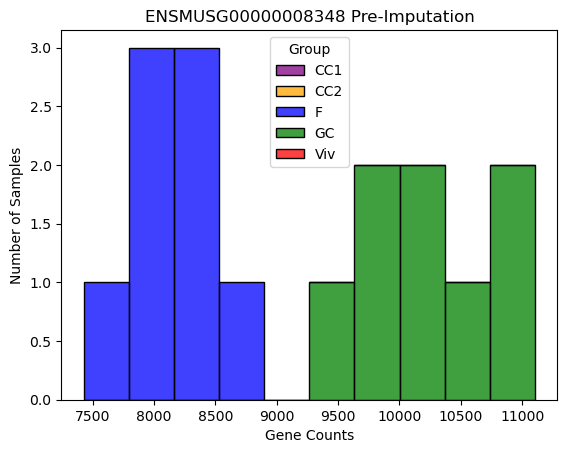

In [49]:
sns.histplot(data=merged_df, x='ENSMUSG00000008348', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('ENSMUSG00000008348 Pre-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

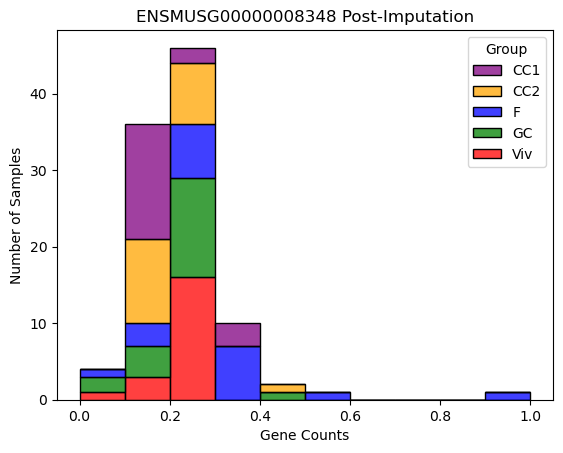

In [50]:
sns.histplot(data=imp_df_knn, x='ENSMUSG00000008348', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('ENSMUSG00000008348 Post-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

**A physiological measurement**

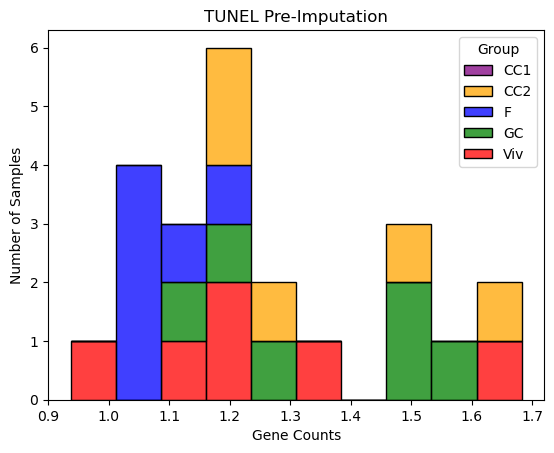

In [51]:
sns.histplot(data=merged_df, x='Total_Area_tunel', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('TUNEL Pre-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

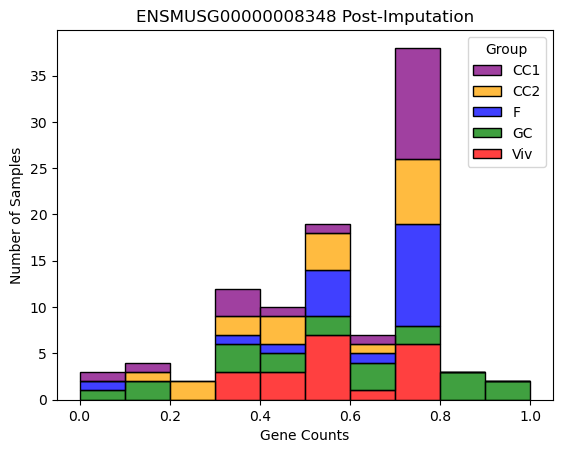

In [52]:
sns.histplot(data=imp_df_knn, x='Total_Area_tunel', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('ENSMUSG00000008348 Post-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

#### PCA

Let's look at the relationships between samples using PCA.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [54]:
def pcaFcn(input_df, title):

  # Separate features and group
  X = df.drop(columns=['Group'])  # Drop the 'Group' column to get features
  y = df['Group']  # Extract the 'Group' column

  # Standardize the features
  X_standardized = StandardScaler().fit_transform(X)

  # Perform PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_standardized)

  # Create a DataFrame for the PCA results
  pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
  pca_df['Group'] = y.values  # Add the group column

  # Plotting

  group_colors = {'GC': 'green', 'F': 'blue', 'Viv': 'red', 'CC1': 'purple', 'CC2': 'orange'}  # Define a custom color mapping for each "Group" label

  plt.figure(figsize=(10, 8))
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Group', palette=group_colors, s=100, alpha=0.5)
  #sns.stripplot(data=pca_df, x='PC1', y='PC2', hue='Group', palette=group_colors, s=10, jitter=True, dodge=True) # Tried using stripplot because of overlapping points
  plt.title(title)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend(title='Group')
  plt.grid(False)
  plt.show()


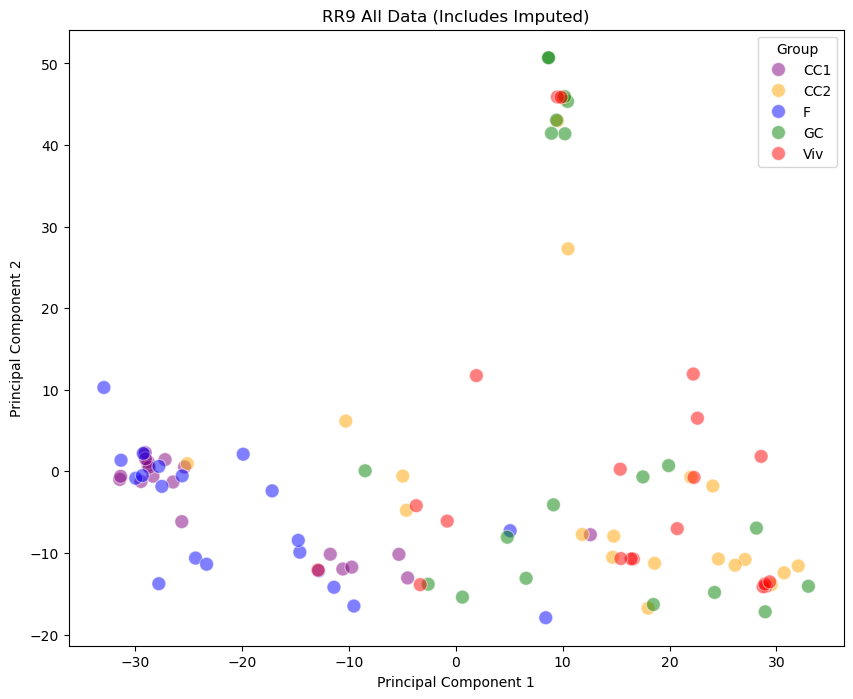

In [55]:
# All imputed data

df = imp_df_knn

pcaFcn(df, 'RR9 All Data (Includes Imputed)')


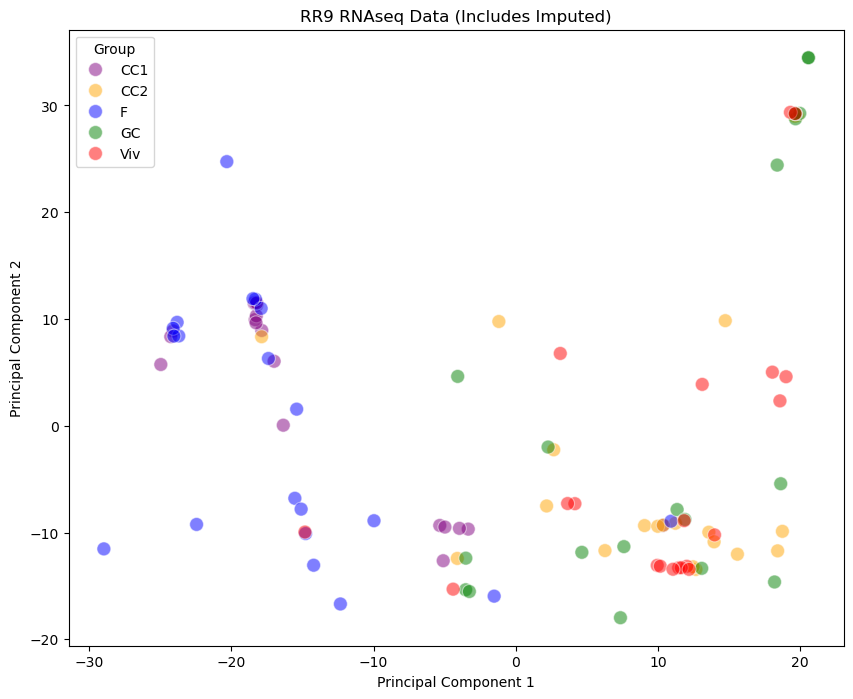

In [56]:
# RNAseq data alone - imputed

columns_list = all_genes.copy()
columns_list.append('Group')
df = imp_df_knn[columns_list]

pcaFcn(df, 'RR9 RNAseq Data (Includes Imputed)')


/tmp/ipykernel_2629168/2389580553.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Imputed'] = imputed_samples


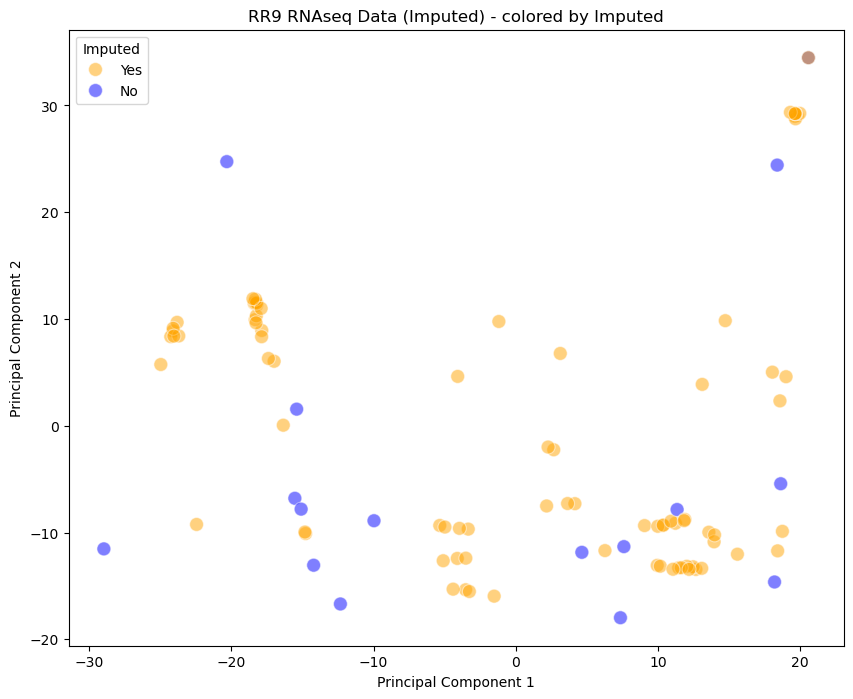

In [57]:
# RNAseq data alone - imputed and colored by yes/no imputed sample

imputed_samples = []
for x in imp_df_knn.index:
  if x in rnaseq['Source Name'].values:
    imputed_samples.append('No')
  else:
    imputed_samples.append('Yes')


columns_list = list(rnaseq.drop(columns='Source Name').columns)
df = imp_df_knn[columns_list]
df['Imputed'] = imputed_samples


# Separate features and group
X = df.drop(columns=['Imputed'])
y = df['Imputed']

# Standardize the features
X_standardized = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Imputed'] = y.values

# Plotting
plt.figure(figsize=(10, 8))
#sns.stripplot(data=pca_df, x='PC1', y='PC2', hue='Imputed', palette={'Yes': 'orange', 'No': 'blue'}, s=10, jitter=True, dodge=True)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Imputed', palette={'Yes': 'orange', 'No': 'blue'}, s=100, alpha=0.5)

plt.title('RR9 RNAseq Data (Imputed) - colored by Imputed')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Imputed')
plt.grid(False)
plt.show()



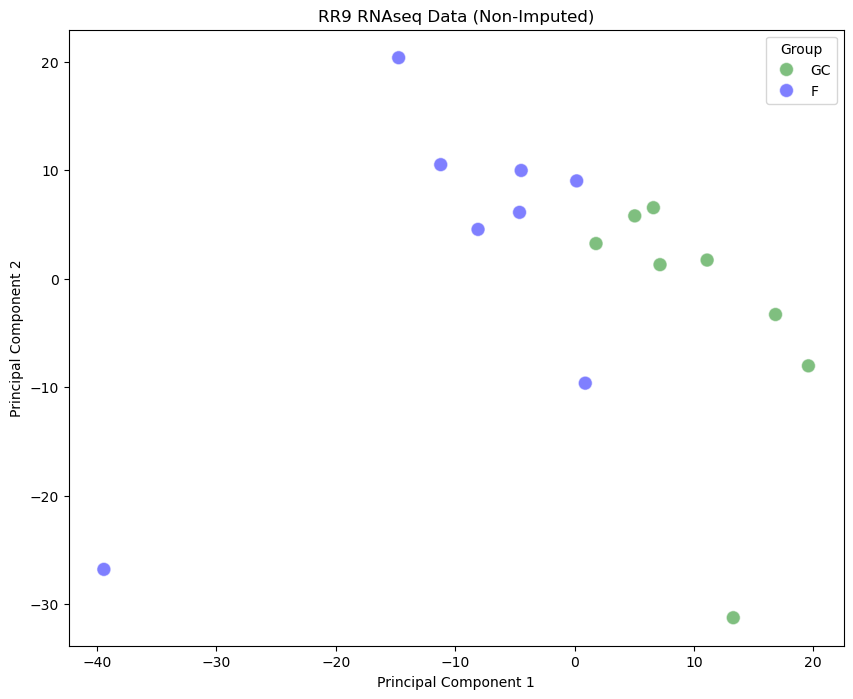

In [58]:
# RNAseq data alone - non imputed

rnaseq_pca = rnaseq.copy()
rnaseq_pca['Group'] = ['GC','GC','GC','GC','GC','GC','GC','GC','F','F','F','F','F','F','F','F']
df = rnaseq_pca.drop(columns=['Source Name'])

pcaFcn(df, 'RR9 RNAseq Data (Non-Imputed)')

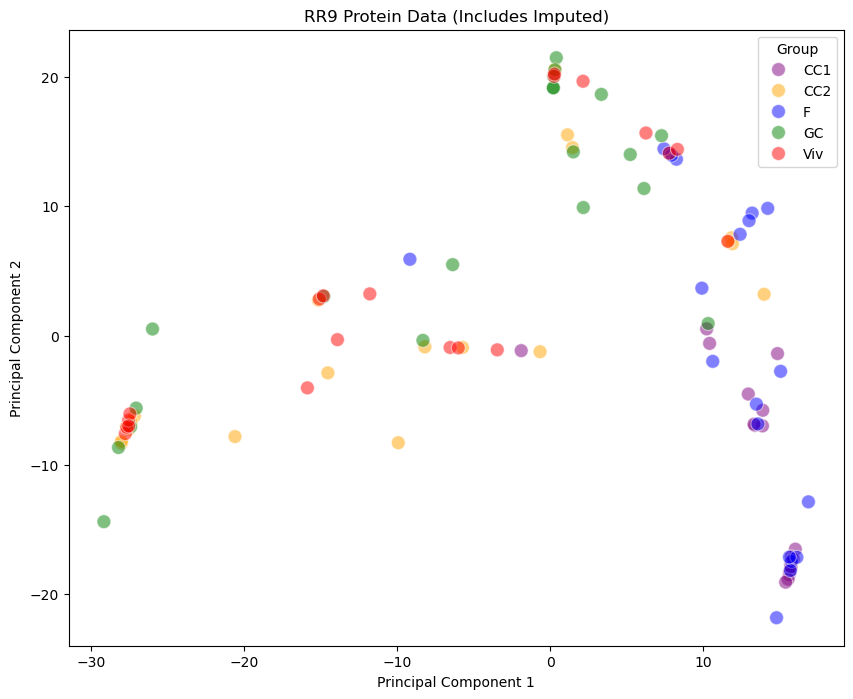

In [59]:
# Protein data alone - imputed

columns_list = all_proteins.copy()
columns_list.append('Group')
df = imp_df_knn[columns_list]

pcaFcn(df, 'RR9 Protein Data (Includes Imputed)')


/tmp/ipykernel_2629168/2361417110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group'] = imp_df_knn['Group']


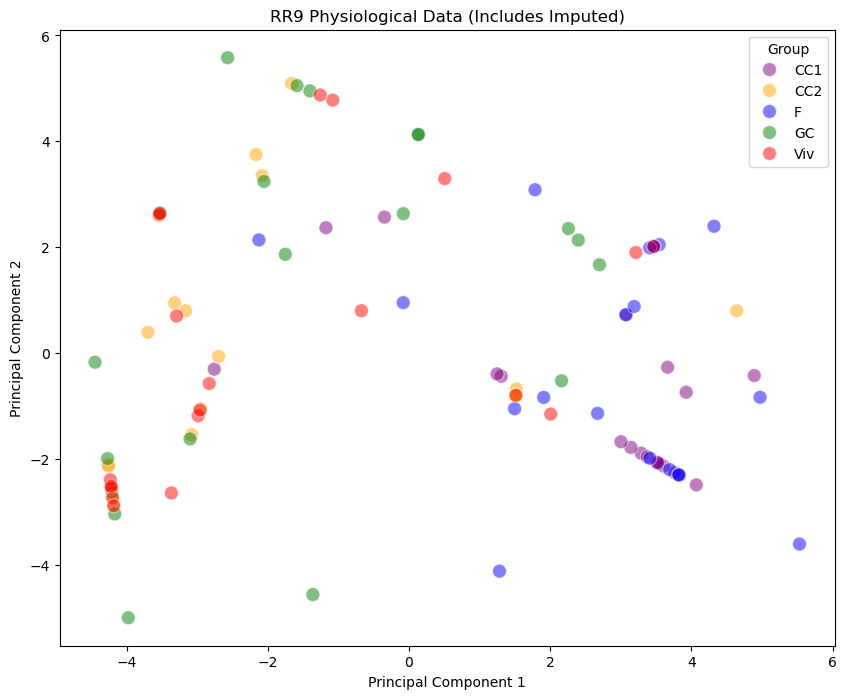

In [60]:
# Physiological data alone - imputed

df = imp_df_knn[[x for x in imp_df_knn.columns if x not in all_genes and x not in all_proteins]]
df['Group'] = imp_df_knn['Group']

pcaFcn(df, 'RR9 Physiological Data (Includes Imputed)')

# Metadata Preparation

Prepare a master dataframe of metadata for all samples.

Using the Metadata API from the OSDR API: https://www.nasa.gov/reference/osdr-public-api/#hds-sidebar-nav-3

In [76]:
# Use OSD-583 (tonometry) since that study contains measurements (and metadata) from all the animals

response = requests.get('https://osdr.nasa.gov/osdr/data/osd/meta/583').json() # pull metadata from API https://www.nasa.gov/reference/osdr-public-api/#hds-sidebar-nav-3

# empty df and lists for columns
meta = pd.DataFrame()

sample_names = []
sex = []
mission_weeks = []
diet = []
group = []

for sam in response['study']['OSD-583']['studies'][0]['materials']['samples']:
  sample_names.append(sam['name'])
  sex.append(sam['characteristics'][3]['value']['annotationValue'])
  mission_weeks.append(sam['characteristics'][4]['value'])
  diet.append(sam['characteristics'][5]['value'])
  group.append(sam['factorValues'][0]['value']['annotationValue'])


meta['Sample Name'] = sample_names
meta['Sex'] = sex
meta['Mission Length Weeks'] = mission_weeks
meta['Diet'] = diet
meta['Group'] = group

# add source name column to match the data df
meta['Sample Name'] = meta['Sample Name'].str.replace('CC2_', 'CC2')
meta['Source Name'] = meta['Sample Name'].str.split('_').str[0]
meta['Source Name'] = meta['Source Name'].str.replace('FViv', 'CC1_')
meta['Source Name'] = meta['Source Name'].str.replace('CC2', 'CC2_')
meta.drop(columns='Sample Name', inplace=True)
meta = meta.rename(columns={'Source Name': 'sample'}) # rename to "sample" since GAN expects it
meta = meta.set_index('sample')


meta

# *** Add spaceflight telemetry data here

,Sex,Mission Length Weeks,Diet,Group
sample,,,,
CC2_10,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_11,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_12,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_13,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_14,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_15,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_16,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_17,male,10,Standard chow (LabDiet5k52),Cohort Control 2
CC2_18,male,10,Standard chow (LabDiet5k52),Cohort Control 2


# Synthetic Data Generation

Use a Generative Adversarial Network (GAN) to generate synthetic data.

https://github.com/nasa/AI4LS/tree/gan-pub


In [62]:
## Mount Google Drive for writing out files

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [63]:
## Change to the desired output directory

# %cd "/content/drive/My Drive/Colab Notebooks"

In [64]:
!pwd

/home/gojian/Dropbox/Code/Python/Notebooks/GeneLab/AI-ML_AWG/Working_Code


In [65]:
## Clone the GAN repo (uncomment if you have not cloned it before)

#!git clone -b gan-pub --single-branch https://github.com/nasa/AI4LS.git


In [66]:
# sort data and metadata by sample/source name

imp_df_knn = imp_df_knn.sort_index()
meta = meta.sort_index()

In [67]:
#imp_df_knn

In [68]:
# write to csv for GAN program to find

meta.to_csv('meta.csv')

imp_df_knn.drop(columns='Group').transpose().to_csv('imp_df_knn.csv', index=True, index_label='gene') # name the index "gene" because GAN expects it


In [69]:
# reduce dims

# python 3.8

'''
-n option specifies the number of genes with the highest variance to keep
-c option specifies the coefficient of variation below which genes are removed
-a option specifies the percentage threshold (out of 100) of genes with zero expression above which genes are removed
-e option specifies the input expression file.
-t option specifies gene type, may be one of the following:
'''

# If you use this script, comment out the function calls for convertIdsToNames() and filterGenesByType() and the pybiomart import statement

!python AI4LS/utils/reduceDim.py -e imp_df_knn.csv -n 10000 -a 90 -t protein_coding -c 1.5


original size:  (2036, 101)


1036 input query terms found no hit:	['Q58DZ4', 'Q3UUT6', 'Q5SX40', 'O70456', 'E9Q942', 'Q9QXC6', 'Q9WVJ5', 'Q545T7', 'J3QMK2', 'P21550',
dims after converting to names:  (2036, 101)
after reducing by removing non-protein-coding genes:  (934, 101)
after reducing by removing when percentage zero is at least alpha:  0.9 (934, 101)
after reducing by coef_var :  1.5 (14, 101)
after reducing by n most varied:  10000 (14, 101)


In [70]:
# increase the number of technical replicates

'''
-e specifies the input expression file
-m specifies the input metadata file
-n specifies the number of times more samples to create
-v specifies the variance to use for the zero-mean gaussian sampling - IS THIS REALLY USED?
-k specifies the metadata key
'''

!python AI4LS/utils/statistically_technical_replicate.py \
-e imp_df_knn__reduced__t_protein_coding_a_0.9_c_1.5_n_10000.csv \
-m meta.csv \
-n 50 \
-v 10


/home/gojian/Dropbox/Code/Python/Notebooks/GeneLab/AI-ML_AWG/Working_Code/AI4LS/utils/statistically_technical_replicate.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_expr_df = pd.concat([temp_expr_df, noised_expr_row])
/home/gojian/Dropbox/Code/Python/Notebooks/GeneLab/AI-ML_AWG/Working_Code/AI4LS/utils/statistically_technical_replicate.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp_expr_df = pd.concat([temp_expr_df, noised_expr_row])
/home/gojian/Dropbox/Code/Python/Noteb

In [71]:
# create a meta JSON file to indicate which meta data are numerical and which are categorical

import json

data = {
    "cat": ["Sex", "Diet", "Group"],
    "num": ["Mission Length Weeks"]
}

filename = "meta.json"

with open(filename, 'w') as file:
    json.dump(data, file, indent=4)

In [72]:
# Create the output folder

!mkdir gan-out

mkdir: cannot create directory ‘gan-out’: File exists


In [ ]:
# This may work when run on command line instead of Google Colab

'''
-ie is the input expression file
-im is the input metadata file
-od is the output directory
-umf is the JSON file defining which categorical and numerical values to use
-e is the number of epochs
-s is the seed for the random number generator
-cd is the checkpoint directory
'''

!python AI4LS/GAN/gen_fake_expr.py \
-ie imp_df_knn__reduced__t_protein_coding_a_0.9_c_1.5_n_10000__expanded_50_10.0.csv \
-im meta__expanded_50_10.0.csv \
-od ~/gan-out  \
-umf meta.json \
-e 10 \
-s 23 \
-cd ~/gan-out

2024-12-19 08:49:06.968534: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 08:49:06.976409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 08:49:06.985518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 08:49:06.988285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 08:49:06.995256: I tensorflow/core/platform/cpu_feature_guar

In [74]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [75]:
!nvidia-smi

Thu Dec 19 08:52:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5000 Ada Gene...    Off |   00000000:01:00.0  On |                  Off |
| 30%   37C    P8             12W /  250W |     220MiB /  32760MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----